**Analysis for the Prediction and the extracted grammer structure by the model**    

This Analysis code needs 1 folder and 2 files in saved_model.   
model_2103   
np_2103.pkl   
tokenizer_2103.pkl   

In [ ]:
ver = 21212;

In [ ]:
INTACT = 0; BLOCK_RECURRENT = 1;  BLOCK_FF = 2; ## BLOCK_FF works only when dropout layer exists (dp_rate>0)
rnn_cond = INTACT;

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "gdrive/My Drive/Colab/NLP"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/Colab/NLP'
/content/gdrive/My Drive/Colab/NLP


In [ ]:
import numpy as np
import joblib
np.set_printoptions(threshold=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

In [ ]:
inc_tmstep_valrate = [16,16,0.9];  lr = 0.004 * np.array([1,1,1,1,1]);   str_c = ['','i','i_dp'];
gr_scale = 10;  dp_rate = 0;  min_fb_gr_b = -1.6;  max_fb_gr_b = 0.0;
p_cell = 192;  dp_through_rate = 0.0;
leaky_relu = 0.0;  p_relu_on = 0;  p_relu =0.0;  sqrt_leak = 0;  cANN_DM = 0;
if ver > 2153 and ver < 2159:  p_cell = 512
if ver > 21964 and ver <= 21969:   sqrt_leak = 1;
if ver > 21059 and ver <= 21060:   cANN_DM = 1;

In [ ]:
w_idx, idx_to_word, sents, loss_his, inc_tmstep_valrate = joblib.load('./saved_model/np_'+'{0:03d}'.format(ver)+'.pkl')

In [ ]:
time_step = np.size(sents,1)//2;      sents_2 = sents + 0;
increments = inc_tmstep_valrate[0];   train_val_rate = inc_tmstep_valrate[2];   ep_lg = (len(loss_his[0])-1)/increments;
if len(inc_tmstep_valrate)>3:  lr = inc_tmstep_valrate[3];  # available after ver2006
if len(inc_tmstep_valrate)>4:  gr_scale = inc_tmstep_valrate[4];
if len(inc_tmstep_valrate)>5:  dp_rate = inc_tmstep_valrate[5];
if len(inc_tmstep_valrate)>6:  min_fb_gr_b = inc_tmstep_valrate[6];
if len(inc_tmstep_valrate)>7:  p_cell = inc_tmstep_valrate[7];
if len(inc_tmstep_valrate)>8:  dp_through_rate = inc_tmstep_valrate[8];
if len(inc_tmstep_valrate)>9:  leaky_relu = inc_tmstep_valrate[9];
if len(inc_tmstep_valrate)>10:  p_relu_on = inc_tmstep_valrate[10];
if len(inc_tmstep_valrate)>11:  p_relu = inc_tmstep_valrate[11];
if len(inc_tmstep_valrate)>12:  sqrt_leak = inc_tmstep_valrate[12];
if len(inc_tmstep_valrate)>13:  max_fb_gr_b = inc_tmstep_valrate[13];
if len(inc_tmstep_valrate)>14:  cANN_DM = inc_tmstep_valrate[14];
increments, ep_lg, lr[0], p_cell, gr_scale, dp_rate, dp_through_rate, leaky_relu, sqrt_leak

(32, 8.0, 0.0064, 192, 1, 0.0, 0.0, 0.02, 1)

In [ ]:
ind_pos = max_fb_gr_b // ((max_fb_gr_b-min_fb_gr_b) /gr_scale)

In [ ]:
if leaky_relu > 0 and sqrt_leak == 1:         leaky_relu_in = np.sqrt(leaky_relu);    leaky_relu_pc = np.sqrt(leaky_relu);
elif leaky_relu > 0:                          leaky_relu_in = 1.0;                    leaky_relu_pc = leaky_relu;
elif leaky_relu == 0 and p_relu_on == 1:      leaky_relu_in = 1.0;                    leaky_relu_pc = 0.0; # dummy (p-relu for pc),
else:                                         leaky_relu_in = 0.0;                    leaky_relu_pc = 0.0; # ReLU in PC and input cells,  ## when leaky_relu == 0 and p_relu_on == 0:
leaky_relu_out = 1.0;

In [ ]:
class custom_RNNCell(layers.AbstractRNNCell):
    def __init__(self, units,  **kwargs):
        super(custom_RNNCell, self).__init__(**kwargs)
        self.units = units
        self.prelu = tf.keras.layers.PReLU(alpha_initializer=tf.initializers.constant(p_relu))

    @property
    def state_size(self):
        return self.units

    def build(self, input_shape):
        self.w_ff = self.add_weight( shape=(input_shape[-1], self.units),
            initializer='he_normal',     name='kernel') # glorot_uniform, he_normal, orthogonal,
        self.w_pc2out = self.add_weight( shape=(self.units, self.units),
            initializer='identity', trainable=False,    name='recurrent_w0')
        self.w_out2in = self.add_weight( shape=(self.units, self.units * gr_scale),
            initializer='identity', trainable=False,    name='recurrent_w1')
        self.w_out2in = tf.concat([tf.eye(self.units) for i in range(gr_scale)],1) # producing multiple copies of states in input layer
        self.b_r_in = self.add_weight( shape=(self.units * gr_scale,),
            name='recurrent_bias',  trainable=False,    initializer='zeros')   # for recurrent input cells
        self.b_r_in = tf.concat([tf.fill([self.units,], (min_fb_gr_b-max_fb_gr_b)*(i-ind_pos)/gr_scale) for i in range(gr_scale)],0) # multiple bias values for different gr populations
        self.w_in2pc = self.add_weight( shape=(self.units * gr_scale, self.units),
            initializer='he_normal',    trainable=True, name='recurrent_w2') #  # recurrent kernel
        self.bias = self.add_weight( shape=(self.units,),
            name='bias',     initializer='zeros')  # 'glorot_normal', 'zeros', 'he_normal'
        self.built = True

    def call(self, inputs, states):
        # === recurrent activity (pc -> input cells) ======
        act_pc = states[0]
        act_out = tf.matmul(act_pc, self.w_pc2out)
        act_out = tf.nn.leaky_relu(act_pc, alpha = leaky_relu_out)
        act_in = tf.matmul(act_out, self.w_out2in)
        act_in = act_in + self.b_r_in
        act_in = tf.nn.leaky_relu(act_in, alpha = leaky_relu_in)
        # ==== PC activity ====
        h = tf.matmul(inputs, self.w_ff);
        h = h + self.bias;
        pc = h + tf.matmul(act_in, self.w_in2pc);
        if leaky_relu == 0 and p_relu_on == 1:          pc = self.prelu(pc)
        else:                                           pc = tf.nn.leaky_relu(pc, alpha = leaky_relu_pc)
        return pc, pc

In [ ]:
##### building the model ######
def seq2vec_model_builder(HIDDEN_DIM):
    ##### input and embedding (one-hot) ######
    encoder_inputs = layers.Input(shape=(time_step, ), dtype='int32',)
    encoder_embedding = layers.Embedding(len(w_idx), len(w_idx), embeddings_initializer='identity', mask_zero=True, trainable=False)(encoder_inputs)
    ##### RNN ##########
    c_cell = custom_RNNCell( HIDDEN_DIM )
    c_cell.initial_state = tf.zeros((1, HIDDEN_DIM), tf.float32)
    encoder_RNN = layers.RNN(c_cell, return_state=True,  name='sRNN')
    encoder_outputs, state_h = encoder_RNN(encoder_embedding)
    ##### output (dense) layer ##########
    dense_layer = layers.Dense(len(w_idx),
                     bias_initializer=keras.initializers.RandomNormal(stddev=0.00001), activation='linear', kernel_constraint=keras.constraints.NonNeg(), name='dense_1')
    outputs = dense_layer(encoder_outputs)
    act_layer = tf.keras.layers.Activation('softmax')
    outputs = act_layer( - outputs) ## $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ the only change from  $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    model = keras.Model(encoder_inputs, outputs)
    return model
model = seq2vec_model_builder(HIDDEN_DIM = p_cell)

In [ ]:
def my_loss(y_true, y_pred):
    row_wise_sum  = tf.reduce_sum(tf.gather(y_true,  [0,1], axis = 1),axis=1)
    valid = tf.reshape(tf.where(tf.equal(row_wise_sum,0)), [-1])
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    return loss_fn(y_true=tf.gather(y_true,  valid, axis = 0),  y_pred=tf.gather(y_pred,  valid, axis = 0))

In [ ]:
def my_top_k_acc(y_true, y_pred):
    row_wise_sum  = tf.reduce_sum(tf.gather(y_true,  [0,1], axis = 1),axis=1)
    valid = tf.where(tf.equal(row_wise_sum,0))     # removing y_true = 0 or 'unk'
    values, y_ind = tf.nn.top_k(y_true, 1);    values, top_k_pred = tf.nn.top_k(y_pred, 5);
    to_top5 = tf.constant( [[ 1, 1, 1, 1, 1]] , dtype=tf.int32 )
    input_y_for_top5 = tf.matmul( tf.reshape(y_ind,[-1, 1]) , to_top5 )
    correct_preds = tf.cast( tf.equal( input_y_for_top5 , top_k_pred ) , dtype=tf.float16)
    suc_pred = tf.reduce_sum(correct_preds, axis=1);
    return tf.reduce_mean( tf.gather(suc_pred,  tf.squeeze(valid), axis = 0) )

In [ ]:
#### optimizer ######
optimizer = keras.optimizers.Adam(learning_rate=0.0036, clipnorm=8.0) # Adam, Adadelta, RMSprop
model.compile(loss=my_loss, optimizer=optimizer, run_eagerly=True, metrics=['categorical_crossentropy', my_top_k_acc])

In [ ]:
if ver<2151:
    model = keras.models.load_model('./saved_model/model_'+'{0:03d}'.format(ver), compile=False)
else:
    model.load_weights('./saved_model/model_'+'{0:03d}'.format(ver) + '/checkpoint/')

In [ ]:
inter_output_model = keras.Model(model.input, model.get_layer('sRNN').output )

In [ ]:
with open('./saved_model/tokenizer_'+'{0:03d}'.format(ver)+'.pkl', 'rb') as handle:
    tokenizer = joblib.load(handle)

In [ ]:
model.get_layer('sRNN')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding (Embedding)       (None, 16, 3001)          9006001   
                                                                 
 sRNN (RNN)                  [(None, 192),             650112    
                              (None, 192)]                       
                                                                 
 dense_1 (Dense)             (None, 3001)              579193    
                                                                 
 tf.math.negative (TFOpLambd  (None, 3001)             0         
 a)                                                              
                                                                 
 activation (Activation)     (None, 3001)              0     

In [ ]:
############### Critical lines for inactivation ################################
if rnn_cond == BLOCK_RECURRENT:
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    # =============== set w_recurrent (192 to 192) as 0 ===============
    w_rnn = layer_dict['sRNN'].get_weights()
    w_rnn[1]  = 0 * w_rnn[1]
    layer_dict['sRNN'].set_weights(w_rnn)
# =================================================================

In [ ]:
print(w_idx)

{'unk': 1, 'the': 2, 'and': 3, 'of': 4, 'to': 5, 'a': 6, 'in': 7, 'was': 8, 'i': 9, 'he': 10, 'it': 11, 'that': 12, 'not': 13, 'his': 14, 'for': 15, 'you': 16, 'is': 17, 'as': 18, 'her': 19, 'with': 20, 'had': 21, 'be': 22, 'she': 23, 'but': 24, 'at': 25, 'on': 26, 'have': 27, 'dr': 28, 'all': 29, 'this': 30, 'him': 31, 'by': 32, 'they': 33, 'from': 34, 'so': 35, 'would': 36, 'were': 37, 'one': 38, 'which': 39, 'no': 40, 'will': 41, 'there': 42, 'are': 43, 'or': 44, 'my': 45, 'could': 46, 'do': 47, 'an': 48, 'what': 49, 'been': 50, 'when': 51, 'zero': 52, 'me': 53, 'their': 54, 'them': 55, 'very': 56, 'if': 57, 'more': 58, 'out': 59, 'who': 60, 'up': 61, 'said': 62, 'we': 63, 'now': 64, 'can': 65, 'little': 66, 'did': 67, 'your': 68, 'than': 69, 'then': 70, 'any': 71, 'some': 72, 'into': 73, 'time': 74, 'about': 75, 'only': 76, 'like': 77, 'has': 78, 'man': 79, 'such': 80, 'must': 81, 'much': 82, 'well': 83, 'other': 84, 'smith': 85, 'good': 86, 'how': 87, 'before': 88, 'know': 89, 'ja

**Text sentenses to evaluate verb processing in the RNN states**

In [ ]:
# break by 5 sentences, insert blank and break by 4 lines.
text = """
The man will sail the boat.                         The man will open the gate.
The man will read the book.                         The beautiful birds catch fish in the river.
You can't live without food for very long.          But there were not enough boats for everyone.
She may turn out the light.                         All the birds were beautiful.
He didn't want birds in his kitchen.                She can lock the door.

He went up on the top deck.                         I should hear the news on the radio.
I've always wanted to be able to speak Japanese.    I can see her shadow through the wall.
I have received a letter from my brother.           She spoke in a very loud voice.
She opened the door and let me in.                  I wrote a letter to her about her future.
I can hardly thank you enough for your kindness.    The ball hit the window and broke it.

I hung my coat on the wall.                         Alice wore a white dress.
They presented their idea to the captain.           We choose the right person to lead the group.
It costs a lot of money to fit up a new office.     The ship was sailing to England.
I have lived here since I was a student.            The boy doesn't like you very much either.
The girl standing over there is my sister.          We lived in London for fifteen years.

She wet her hands with water.                       She closed her eyes.
She has visited there many times.                   After a while, she fell asleep.
He took the salt out of the kitchen sink.           She wanted to see the news about the storm.
He looked at the stranger with concern.             He turned the key in the lock.
He returned from texas with his lovely new bride.   Goodness, I wonder if he knows.

The weather is getting worse day by day.            He was walking down the street.
These sailors showed great courage in the whaling.  She broke her leg in the fall.
My friend threw the ball back over the fence.       We employed a lawyer to settle the trouble.
He begged money in the streets.                     She stretched her arms out.
She calls me crazy and stupid.                      She sailed the boat without any help.


You may open your eyes.                             I am glad to see you again.
I met you here last year.                           This is a picture he took.
You have studied it for two years.                  It helped us complete the task.
Congress is the largest division.                   He had a light breakfast and dinner.
She tried to sleep, but she couldn't.               She is a pretty mistress.

He swept all the pieces of food into the dust box.  He said it would rain a lot.
Sorry, I thought you were someone else.             We saw a baby whale in the sea.
I knew nothing of his business either.              We wish you were here with us.
Green forest turns red in the autumn.               She read the letter more carefully the second time.
She lived in England during the winter.             We followed the path along the river.

They answered the strange question in turn.         He spent most of his life at home.
I will send a message to you.                       He was reading a book.
I've never played cards.                            He declared his love to her.
But I'm telling the truth.                          She leaves her house in the morning every day.
You must have suffered from a cold.                 It all sounds very interesting.

We crossed the river in a boat.                     She nodded her head with ease.
His voice sounded faint and far away.               The sea water swept over the deck.
The man will turn the key.                          I have seen you before.
It is difficult for me to speak English.            I always eat breakfast early in the morning to avoid the rush.
I have an aunt who lives in Rome.                   This is a picture which he took yesterday.

Just now I have finished my work.                   This picture shows people walking on the boat.
Leaders come together to talk about plans for laws. I always drink tea with his breakfast.
She opened her book.                                He put the penny on the table.
The wind was starting to blow.                      He told people to stay home.
People get less active as they get older.           The worst men often give the best advice.


We all felt sorry for his death.                    Dr Smith brought a bottle of wine to the party.
I suppose you're right.                             She cut the meat into small pieces.
Anne suddenly appeared in the room.                 She didn't pay any attention to me at all.
She carried her baby in her arms.                   His friends regard him as a man of the word.
She drew a picture of me.                           The whaling ship came back to nantucket.

He lives in a white house.                          I'm acquainted with that person.
He helped me out with my task.                      He was always asking for money.
I've been eating too much fish.                     He tied a rope around his neck.
Every picture tells a story.                        We'll be staying at home at this moment.
The ship sank to the bottom of the sea.             The man should pay the money.


She hasn't read the book yet.                       The boys want you to come here.
She did not eat anything until she was saved.       This is a ship that goes to London.
The picture which she painted is beautiful.         The picture that he took is very good.
English is spoken by many people in the world.      They build a house out of wood in the forest.
The ship sink to the bottom of the sea.             Some people have more money than others.

All of us ate fish for dinner.                      After a while, she fell asleep.
He should sweep the floor because there is bread pieces.     Her car was in the street.
We never know the worth of water until the well is dry.      He took care of his sick mother.
I may find his lost dog.                            I haven't seen you for years.
You can leave it to me.                             His dream has become a reality.

She became extremely sad after her mother's death.  He started his own business last year.
We were just talking about his new friend.          I paid the money for the present.
She must place a cup on the table.                  He is writing a history of the town for students.
I'm going to miss you very much.                    She could close the gate behind her.
He cannot raise his arms above his head.            You should listen to the words of your mother.


She drove the car into the narrow path.             He informed me about your late arrival.
I should drive along the road.                      My sister won first prize for her singing.
The hard weather could sink the ship.               We had sang a beautiful song together.
You may close the door.                             I could cross the street.
I was happy to meet you.                            The news made her happy so much.

I'm sorry to be late.                               A great white sharks have a sharp sense of smell.
She should tell me about his evil conduct.          I've never spoken ill of him in my life.
She seated herself at her desk.                     The man may hear the noise.
I told you to open the window.                      I have known him since I was a child.
She has written a few books on whales.              It is the flower of her country.

You shouldn't say things like that.                 I'm feeling a little sad this afternoon.
It is dangerous to swim with sharks up close.       I doubt the truth of his words.
You can't reach the mountain.                       You have studied English for two years.
The bird spread its wings.                          I can try but I can't promise.
The ship had many rooms for guests.                 All good things came to an end.

Emma shook her head with tears.                     She burst into tears and ran from the kitchen.
She shed tears at her wedding.
"""

In [ ]:
########## no need to indent.
v_n = [
np.array([1,1,2,3,44,42]),                          np.array([1,1,2,3,44,42]),
np.array([1,1,2,3,44,42]),                          np.array([1,1,1,2,42,0,0,0]),
np.array([1,2,0,3,0,0,0,0,0]),                      np.array([0,1,2,0,5,5,0,0]),
np.array([1,2,3,61,62,62]),                         np.array([1,1,1,2,5]),
np.array([1,2,0,3,42,0,0,0]),                       np.array([1,2,3,44,42]),

np.array([1,2,61,61,62,62,62]),                     np.array([1,2,3,44,42,0,0,0]),
np.array([1,2,0,3,0,0,0,0,0,0]),                    np.array([1,2,3,44,42,0,0,0]),
np.array([1,2,3,44,42,0,0,0]),                      np.array([1,2,0,0,0,0,0]),
np.array([1,2,44,42,0,0,0,0]),                      np.array([1,2,44,42,0,0,0,0,0]),
np.array([1,2,0,3,41,0,0,0,0]),                     np.array([1,1,2,44,42,0,0,0]),

np.array([1,2,44,42,0,0,0]),                        np.array([1,2,44,44,42]),
np.array([1,2,44,41,61,62,62]),                     np.array([1,2,44,44,42,0,0,0,0]),
np.array([1,2,44,44,44,42,0,0,0,0,0,0]),            np.array([1,1,2,3,61,62]),
np.array([1,2,3,0,0,0,0,0,0]),                      np.array([1,1,2,0,3,41,0,0,0]),
np.array([1,1,0,0,0,2,5,5]),                        np.array([1,2,61,62,0,0,0]),

np.array([1,2,44,42,0,0]),                          np.array([1,2,44,42]),
np.array([1,2,3,0,0,0]),                            np.array([0,0,0,1,2,5]),
np.array([1,2,44,42,0,0,0,0,0]),                    np.array([1,2,0,0,0,0,0,0,0]),
np.array([1,2,61,62,62,0,0]),                       np.array([1,2,44,42,0,0,0]),
np.array([1,2,61,62,0,0,0,0,0]),                    np.array([0,1,2,0,0,0]),

np.array([1,1,2,3,5,0,0,0]),                        np.array([1,2,3,61,62,62]),
np.array([1,1,2,44,42,0,0,0]),                      np.array([1,2,44,42,0,0,0]),
np.array([1,1,2,44,42,0,0,0,0]),                    np.array([1,2,44,42,0,0,0,0]),
np.array([1,2,42,0,0,0]),                           np.array([1,2,44,42,0]),
np.array([1,2,41,5,0,5]),                           np.array([1,2,44,42,0,0,0]),


np.array([1,2,3,44,42]),                            np.array([1,2,5,0,0,0,0]),
np.array([1,2,41,0,0,0]),                           np.array([1,2,5,5,0,0]),
np.array([1,2,3,41,0,0,0]),                         np.array([1,2,41,0,0,0]),
np.array([1,2,44,44,42]),                           np.array([1,2,44,44,42,0,42]),
np.array([1,2,0,0,0,0,0,0]),                        np.array([1,2,5,5,5]),

np.array([1,2,44,44,44,0,0,0,0,0,0]),               np.array([1,2,41,0,0,0,0]),
np.array([0,1,2,0,0,0,0]),                          np.array([1,2,44,44,42,0,0,0]),
np.array([1,2,42,0,0,0,0]),                         np.array([1,2,0,0,0,0,0]),
np.array([1,1,2,5,0,0,0]),                          np.array([1,2,44,42,0,0,0,0,0]),
np.array([1,2,61,62,0,0,0]),                        np.array([1,2,44,42,0,0,0]),

np.array([1,2,44,44,42,0,0]),                       np.array([1,2,44,44,44,42,0,0]),
np.array([1,2,3,44,42,0,0]),                        np.array([1,2,3,44,42]),
np.array([1,2,0,3,42]),                             np.array([1,2,44,42,0,0]),
np.array([0,1,2,3,44,42]),                          np.array([1,2,44,42,0,0,0,0,0]),
np.array([1,2,3,3,61,62,62]),                       np.array([1,0,2,0,5]),

np.array([1,2,44,42,0,0,0]),                        np.array([1,2,44,42,0,0]),
np.array([1,1,2,5,0,5,5]),                          np.array([1,1,1,2,61,62,62]),
np.array([1,1,2,3,44,42]),                          np.array([1,2,3,41,0]),
np.array([1,2,5,0,0,0,0,0]),                        np.array([1,0,2,42,0,0,0,0,0,0,0,0]),
np.array([1,2,44,42,0,0,0,0]),                      np.array([1,2,5,5,0,0,0,0]),

np.array([0,0,1,2,3,44,42]),                        np.array([1,1,2,42,0,0,0,0]),
np.array([1,2,0,0,0,0,0,0,0]),                      np.array([1,0,2,42,0,0,0]),
np.array([1,2,44,42]),                              np.array([1,2,44,42,0,0,0]),
np.array([1,1,2,3,0,0]),                            np.array([1,2,42,0,0,0]),
np.array([1,2,5,5,0,0,0,0]),                        np.array([1,1,1,0,2,44,44,42]),


np.array([1,0,2,5,0,0,0]),                          np.array([1,1,2,41,42,44,44,0,0,0]),
np.array([1,2,0,0,0]),                              np.array([1,2,44,42,0,0,0]),
np.array([1,0,2,0,0,0]),                            np.array([1,2,0,3,44,42,61,62,0,0]),
np.array([1,2,44,42,0,0,0]),                        np.array([1,1,2,41,0,0,0,0,0]),
np.array([1,2,44,42,0,0]),                          np.array([1,1,1,2,0,61,62,62]),

np.array([1,2,61,62,62,62]),                        np.array([1,2,61,62,62]),
np.array([1,2,41,0,61,62,62]),                      np.array([1,2,0,3,61,62]),
np.array([1,2,3,3,44,44,42]),                       np.array([1,2,44,42,0,0,0]),
np.array([1,1,2,44,42]),                            np.array([1,2,3,3,61,62,0,0,0]),
np.array([1,1,2,61,62,62,62,62,62]),                np.array([1,1,2,3,44,42]),

np.array([1,2,0,3,44,42,0]),                        np.array([1,1,2,41,0,0,0]),
np.array([1,2,0,3,42,0,0,0,0]),                     np.array([1,2,5,5,0,0,0,0]),
np.array([1,1,0,0,0,2,5]),                          np.array([1,1,0,0,0,2,0,5]),
np.array([1,2,3,61,62,62,0,0,0]),                   np.array([1,2,44,42,0,0,0,0,0,0]),
np.array([1,1,2,61,62,62,0,0,0]),                   np.array([1,1,2,44,42,0,0]),

np.array([1,1,1,2,42,0,0]),                         np.array([0,0,0,1,2,5]),
np.array([1,2,3,44,42,0,0,0,0,0]),                  np.array([1,1,2,61,62,62]),
np.array([1,0,2,41,42,44,44,0,0,0,0,0]),            np.array([1,2,42,0,0,0,0]),
np.array([1,2,3,44,44,42]),                         np.array([1,2,0,3,41,0,0]),
np.array([1,2,3,41,0,0]),                           np.array([1,1,2,3,5,5]),

np.array([1,2,0,5,0,0,0,0,0]),                      np.array([1,2,44,44,42,0,0]),
np.array([1,2,0,3,61,62,62,62]),                    np.array([1,2,44,42,0,0,0]),
np.array([1,2,44,42,0,0,0]),                        np.array([1,2,3,44,42,44,44,44,0,0]),
np.array([1,2,3,0,0,0,0,0]),                        np.array([1,2,3,44,42,0,0]),
np.array([1,2,3,44,42,0,0,0]),                      np.array([1,2,3,61,62,62,0,0,0]),


np.array([1,2,44,42,61,62,62,62]),                  np.array([1,2,41,0,0,0,0]),
np.array([1,2,3,61,62,62]),                         np.array([1,1,2,44,42,0,0,0]),
np.array([1,1,1,2,3,44,42]),                        np.array([1,2,44,44,42,0]),
np.array([1,2,3,44,42]),                            np.array([1,1,2,3,44,42]),
np.array([1,2,5,0,0,0]),                            np.array([1,1,2,41,5,0,0]),

np.array([1,2,5,0,0,0]),                            np.array([1,1,1,1,2,44,44,42,0,0]),
np.array([1,2,3,41,0,0,0,0]),                       np.array([1,2,0,3,44,44,44,0,0,0]),
np.array([1,2,41,61,62,62]),                        np.array([1,1,2,3,44,42]),
np.array([1,2,41,0,0,0,0]),                         np.array([1,2,3,41,0,0,0,0,0]),
np.array([1,2,3,44,44,42,0,0]),                     np.array([1,2,5,5,0,0,0]),

np.array([1,2,0,3,42,0,0]),                         np.array([1,2,3,0,0,0,0,0]),
np.array([1,2,5,0,0,0,0,0,0]),                      np.array([1,2,44,42,0,0,0]),
np.array([1,2,0,3,44,42]),                          np.array([1,2,3,41,0,0,0]),
np.array([1,1,2,44,42]),                            np.array([1,2,3,0,0,0,0,0]),
np.array([1,1,2,44,42,0,0]),                        np.array([1,1,1,2,61,62,62]),

np.array([1,2,44,42,0,0]),                          np.array([1,2,61,62,0,0,0,0,0]),
np.array([1,2,44,0,0,0]),


]
## manual labeling (1, subjective.  2, verb (1st).  3, verb (2nd). 41, object-pronoun.  42, object-noun. 43, object-proper noun. 44, object-other.  5, complement.  61, preposition following verb. 62, word after preposition. 0, the others )
## (2 or 3) verb or auxiliary verb  61, preposition for verb. 62, word after preposition (ex I live in London=1,2,61,62)

In [ ]:
######### svo is simplified version of v_n ##############
svo = []
for i in range(len(v_n)):
    v_n_2 = v_n[i]+0;   v_n_2[np.logical_and(v_n_2>=40,v_n_2<50)] = 4;
    v_n_2[v_n_2==3] = 2; # V2 to V1
    v_n_2[v_n_2==5] = 4; # C to O
    svo.append(v_n_2)

In [ ]:
##### preprocessing of the text #####
text = text.replace(".", ".  ");
text = text.replace("aren't", "are not");   text = text.replace("cannot", "can not");     text = text.replace("can't", "can not");     text = text.replace("couldn't", "could not");
text = text.replace("didn't", "did not");   text = text.replace("doesn't", "does not");   text = text.replace("don't", "do not");      text = text.replace("gonna", "going to");
text = text.replace("hadn't", "had not");   text = text.replace("hasn't", "has not");     text = text.replace("haven't", "have not");  text = text.replace("He'll", "He will");       text = text.replace("he'll", "he will");
text = text.replace("Here's", "Here is");   text = text.replace("here's", "here is");     text = text.replace("I'd", "I would");       text = text.replace("I'll", "I will");         text = text.replace("I'm", "I am");
text = text.replace("isn't", "is not");     text = text.replace("it'll", "it will");      text = text.replace("It'll", "It will");     text = text.replace("It's", "It is");          text = text.replace("it's", "it is");
text = text.replace("I've", "I have");      text = text.replace("She'll", "She will");    text = text.replace("she'll", "she will");   text = text.replace("shouldn't", "should not");
text = text.replace("that's", "that is");   text = text.replace("That's", "That is");     text = text.replace("They'll", "They will"); text = text.replace("they'll", "they will");
text = text.replace("They're", "They are"); text = text.replace("they're", "they are");   text = text.replace("they've", "they have"); text = text.replace("They've", "They have");
text = text.replace("wanna", "want to");    text = text.replace("wasn't", "was not");     text = text.replace("We'd", "We would");     text = text.replace("we'd", "we would");
text = text.replace("we'll", "we will");    text = text.replace("We'll", "We will");      text = text.replace("we've", "we have");     text = text.replace("We've", "We have");       text = text.replace("What's", "What is");
text = text.replace("won't", "will not");   text = text.replace("wouldn't", "would not"); text = text.replace("You'll", "You will");  text = text.replace("you'll", "you will");
text = text.replace("You're", "You are");   text = text.replace("you're", "you are");     text = text.replace("You've", "You have");   text = text.replace("You've", "You have");     text = text.replace("you've", "you have");
text = text.replace("'", "");    # text = text.replace('\n', ' ');

In [ ]:
import nltk
nltk.download('punkt')
sents1 = nltk.tokenize.sent_tokenize(text); ## generating sentenses

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
sents = tokenizer.texts_to_sequences(sents1);          seq_length = 2 * time_step;
sents = preprocessing.sequence.pad_sequences(sents, maxlen=seq_length-time_step+1, padding='pre', truncating='post')
sents = np.concatenate( (np.zeros((np.size(sents,0),time_step-1)),sents), axis=1)
sents = np.concatenate( (sents, -np.ones((np.size(sents,0),1))), axis=1)
##### sents were replaced with the evaluation text sentenses given in this file #####

In [ ]:
valid = range(len(svo)) # all sents
sents = sents[valid,:];     svo = [svo[i] for i in valid];    v_n = [v_n[i] for i in valid];

In [ ]:
x, y = [],[];   ## input and output of the prediction model with easier english sentenses
for line in range(len(sents)):
    for i in range(len(sents[line])-time_step):
        if np.sum(sents[line][i:i+time_step])==0:  continue
        x.append(sents[line][i:i+time_step]);     y.append(sents[line][i+time_step]);

In [ ]:
svo_1,svo_y = [],[];   sv_2 = np.zeros((len(svo),2*time_step+1));   sv_2[:,-1] = -1;  # correct labels for the sentenses
for line in range(len(svo)):
    svo[line] = np.where(svo[line] > 60, 0, svo[line]);   sv_2[line,-len(svo[line])-1:-1]=svo[line]+1;
    for i in range(len(sv_2[line])-time_step):
        if np.sum(sents[line][i:i+time_step])==0:   continue
        svo_1.append(sv_2[line,i+time_step-1]);   svo_y.append(sv_2[line,i+time_step]); # svo_1: last word,  svo_y: next word,

In [ ]:
vo_1,vo_y = [],[];   vo_2 = np.zeros((len(v_n),2*time_step+1));   vo_2[:,-1] = -1;  # correct labels for the sentenses
for line in range(len(v_n)):
    v_n[line] = np.where(v_n[line] > 100, 0, v_n[line]);   vo_2[line,-len(v_n[line])-1:-1]=v_n[line]+1;
    for i in range(len(vo_2[line])-time_step):
        if np.sum(sents[line][i:i+time_step])==0:   continue
        vo_1.append(vo_2[line,i+time_step-1]);   vo_y.append(vo_2[line,i+time_step]); # vo_1: last word,  vo_y: next word,

In [ ]:
svo_1 = np.array(svo_1);  svo_y = np.array(svo_y);
vo_1 = np.array(vo_1);    vo_y = np.array(vo_y);

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
w_dcn = layer_dict['dense_1'].get_weights()

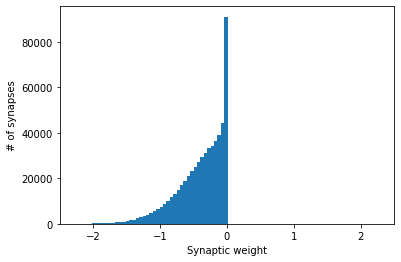

In [ ]:
fig = plt.figure()
plt.hist(np.reshape(-w_dcn[0],[-1,]), bins=100, range=[-2.58,2.5]);
plt.ylabel("# of synapses"); plt.xlabel('Synaptic weight')
plt.xlim([-2.5,2.5]);

In [ ]:
fig.savefig('./saved_img/v'+'{0:03d}'.format(ver)+'_GABA_1' +str_c[rnn_cond]+ '.pdf')

In [ ]:
from termcolor import colored

In [ ]:
##### Correct rate of validation in the training period  ######
print(loss_his[3][-4:].tolist())
100*np.mean(loss_his[3][-4:])

[0.36981791257858276, 0.3694635331630707, 0.36880984902381897, 0.36736077070236206]


36.88630163669586

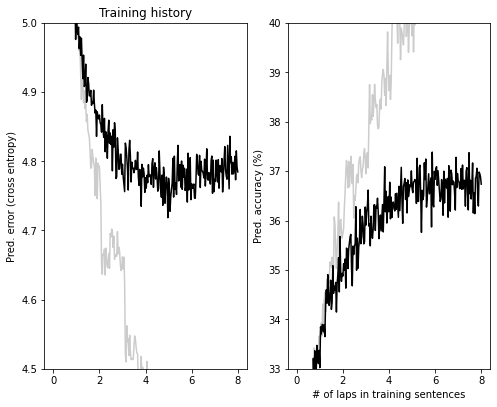

In [ ]:
plt.figure(figsize=(8, 14)) # figure area
plt.subplot(2,2,1);
plt.plot(np.arange(len(loss_his[0]))/increments,loss_his[0], color=[0.8, 0.8, 0.8])
plt.plot(np.arange(len(loss_his[2]))/increments,loss_his[2], color=[0, 0, 0])
plt.ylabel("Pred. error (cross entropy)"); plt.title('Training history')
plt.ylim([4.5,5]);
plt.subplot(2,2,2);
plt.plot(np.arange(len(loss_his[1]))/increments,loss_his[1]*100, color=[0.8, 0.8, 0.8])
plt.plot(np.arange(len(loss_his[3]))/increments,loss_his[3]*100, color='black')
plt.xlabel("# of laps in training sentences"),  plt.ylabel("Pred. accuracy (%)");
plt.ylim([33,40]);

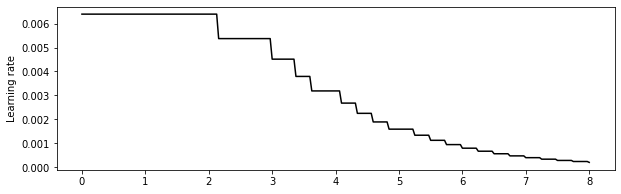

In [ ]:
plt.figure(figsize=(10, 3)) # figure area
plt.plot(np.arange(len(lr))/increments,lr, color=[0, 0, 0])
plt.ylabel("Learning rate");

In [ ]:
x = np.stack(x);  y = np.stack(y);

In [ ]:
svo_y[y==1] = 99;      vo_y[y==1] = 0           # exclude "unkown"
svo_1[x[:,-1]==1] = 0;

In [ ]:
##### model prediction ######
y_pred = model.predict(x, verbose=0);
y_pred_idx = np.argsort(-y_pred)[:,:10];
##### RNN state prediction ######
rnn_output, y_pred_state = inter_output_model.predict(x)

42/42 [==============================] - 2s 42ms/step


In [ ]:
x_0 = np.zeros((1,16));
##### model prediction ######
y_pred_0 = model.predict(x_0, verbose=0);
y_pred_idx_0 = np.argsort(-y_pred_0)[:,:10];
##### RNN state prediction ######
rnn_output_0, y_pred_state_0 = inter_output_model.predict(x_0)

1/1 [==============================] - 0s 44ms/step


In [ ]:
##### chance level for val 2  ######
ch_top_k_mat = np.sum(np.ones((len(y),1))*np.array([2,3,4,5,6]) == (np.reshape(y,[-1,1]) * np.array([1,1,1,1,1])), axis=1);
ch_all = 100*np.mean(ch_top_k_mat[y>1]); # removing -1(EOS) and 1 (unknown)
ch_all # prediction correct rate, # of prediction

16.06986899563319

In [ ]:
##### Correct rate for val 2  ######
acc_top_k_mat = np.sum(y_pred_idx[:,:5] == (np.reshape(y,[-1,1]) * np.array([1,1,1,1,1])), axis=1);
val2_acc_all = 100*np.mean(acc_top_k_mat[y>1]); # removing -1(EOS) and 1 (unknown)
val2_acc_all,  np.sum(y>1)  # prediction correct rate, # of prediction

(37.030567685589524, 1145)

In [ ]:
val2_acc_41 = 100*np.mean(acc_top_k_mat[np.array(vo_y)==(41+1)]);
val2_acc_41, np.sum(np.array(vo_y)==(41+1)), # prediction correct rate for 41(pronoun) , # of prediction

(52.17391304347826, 23)

In [ ]:
val2_acc_42 = 100*np.mean(acc_top_k_mat[np.array(vo_y)==(42+1)]);
val2_acc_42, np.sum(np.array(vo_y)==(42+1)), # prediction correct rate for 42(V-noun) (verb-noun) , # of prediction

(11.702127659574469, 94)

In [ ]:
val2_acc_61 = 100*np.mean(acc_top_k_mat[np.array(vo_y)==(61+1)]);
val2_acc_61, np.sum(np.array(vo_y)==(61+1)), # prediction correct rate for 61(preposition) , # of prediction

(70.0, 30)

In [ ]:
val2_acc_0 = 100*np.mean(acc_top_k_mat[np.array(vo_y)==(0+1)]);
val2_acc_0, np.sum(np.array(vo_y)==(0+1)), # prediction correct rate for 0 (other words) , # of prediction

(41.49377593360996, 482)

In [ ]:
val2_acc_a_41_42_61_0 = [val2_acc_all,val2_acc_41,val2_acc_42,val2_acc_61,val2_acc_0]

In [ ]:
np.size(y)

1328

In [ ]:
num_ana = np.size(y);
states, r_in, r_out, vocab, wd, sv, vo = [],[],[],[],[],[],[]; n_0 = np.zeros(2);   first_w = np.zeros(num_ana);

for k in range(num_ana):
    x_pred = x[k:k+1,:];    w_char = [];   result = '';    x_onehot = np.zeros((1,3001));
    for i in range(time_step):      w_char.append(idx_to_word[x[k][i]])
    x_onehot[0,int(x_pred[0,-1])]=1;       r_in.append(x_onehot)
    ##### RNN state prediction and converting it to str ######
    rnn_states = y_pred_state[k:k+1,:];        states.append(rnn_states);
    vocab.append(idx_to_word[x_pred[0,-1]]);   wd.append(x_pred[0,-1]);  sv.append(svo_1[k]);  # vo.append(vo_1[k])
    ##### model prediction and converting it to str ######
    prediction = y_pred[k:k+1,:];     index = np.argsort(-prediction)[:,:10];    r_out.append(prediction);
    for m in range(np.size(index)):   result = result + idx_to_word[index[:,m].item()] + ' '
    #### first word detection #####
    n_0[0] = n_0[1];     n_0[1] = np.sum(x_pred == 0);
    if n_0[0] < n_0[1]:     first_w[k] = 1;
    #### output ####
    if sum(first_w)==81 and first_w[k] == 1:  print('##################################################### 80 ###########################################################')
    if svo_y[k]>=0:
        char = ' '.join(w_char)
        print(char)
        if svo_y[k]==2+1:     print('    answer:'+colored(str(idx_to_word[y[k]]),'red'))
        else:                 print('    answer:'+str(idx_to_word[y[k]]))
        print('    prediction:'+str(result))

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ the
    answer:man
    prediction:old little first next man two only other same whale 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ the man
    answer:will
    prediction:who was is had of said in and at has 
_ _ _ _ _ _ _ _ _ _ _ _ _ the man will
    answer:sail
    prediction:be not come have go never take make soon run 
_ _ _ _ _ _ _ _ _ _ _ _ the man will sail
    answer:the
    prediction:with for in and on to the at down it 
_ _ _ _ _ _ _ _ _ _ _ the man will sail the
    answer:boat
    prediction:same first work top hill ship deck next door right 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ the
    answer:man
    prediction:old little first next man two only other same whale 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ the man
    answer:will
    prediction:who was is had of said in and at has 
_ _ _ _ _ _ _ _ _ _ _ _ _ the man will
    answer:open
    prediction:be not come have go never take make soon run 
_ _ _ _ _ _ _ _ _ _ _ _ the man will open
    answer:the
    prediction:the and it to w

In [ ]:
first_w1 = np.cumsum(first_w);
first_w_idx = np.concatenate((np.reshape(np.where(first_w==1),[-1]), np.array(np.shape(first_w))), axis=0 );

In [ ]:
first_w2 = np.zeros(num_ana);  first_w3 = np.zeros(num_ana);
for i in range(np.size(first_w_idx)-1):
    first_w2[first_w_idx[i]:first_w_idx[i+1]] =  first_w_idx[i+1] - first_w_idx[i];
    first_w3[first_w_idx[i]:first_w_idx[i+1]] =  np.arange(first_w_idx[i+1] - first_w_idx[i]);
col_w = first_w3/(first_w2-1);

In [ ]:
############ accuracy (correct rate) for each sentence #################
acc_ea = [100*np.mean(acc_top_k_mat[first_w1==(i+1)]) for i in range(int(np.max(first_w1)))]
acc_ea = np.array(acc_ea)

In [ ]:
############ accuracy (correct rate) for each location in the sentence #################
acc_loc = [100*np.mean(acc_top_k_mat[first_w3==(i)]) for i in range(8)];    acc_loc = np.array(acc_loc);
n_loc = [np.sum(first_w3==(i)) for i in range(8)]
acc_loc, n_loc

(array([31.1, 40.4, 36.6, 39.9, 37.6, 27.3, 17.6, 21.7]),
 [183, 183, 183, 183, 181, 165, 125, 69])

In [ ]:
############ accuracy (correct rate) for boat, book, noise #################
loc_boat = np.where(first_w1==1); loc_boat=loc_boat[0][-1]-1
acc2_boat = np.sum((y_pred_idx[loc_boat,:5] == ( w_idx['boat'] * np.array([1,1,1,1,1])))) or np.sum((y_pred_idx[loc_boat,:5] == ( w_idx['ship'] * np.array([1,1,1,1,1]))))
loc_noise = np.where(first_w1==2); loc_noise=loc_noise[0][-1]-1
acc2_noise = np.sum((y_pred_idx[loc_noise,:5] == ( w_idx['noise'] * np.array([1,1,1,1,1])))) or np.sum((y_pred_idx[loc_noise,:5] == ( w_idx['voice'] * np.array([1,1,1,1,1]))))
loc_book = np.where(first_w1==3); loc_book=loc_book[0][-1]-1
acc2_book = np.sum((y_pred_idx[loc_book,:5] == ( w_idx['book'] * np.array([1,1,1,1,1])))) or np.sum((y_pred_idx[loc_book,:5] == ( w_idx['letter'] * np.array([1,1,1,1,1]))))

acc2_boat_noise_book = [float(acc2_boat), float(acc2_noise), float(acc2_book)]

In [ ]:
w_idx['ship']

248

In [ ]:
y_pred_idx[loc_boat,:5]

array([159,  98, 208, 466, 812])

In [ ]:
print(acc_ea)

[16.7 33.3 33.3 25.0 44.4 25.0 33.3 40.0 50.0 20.0 28.6 25.0 50.0 12.5
 37.5 42.9 50.0 33.3 33.3 25.0 14.3 20.0 14.3 33.3 33.3 16.7 44.4 33.3 0.0
 42.9 16.7 50.0 16.7 66.7 33.3 44.4 28.6 14.3 22.2 50.0 12.5 50.0 12.5
 42.9 22.2 0.0 33.3 40.0 0.0 14.3 40.0 57.1 16.7 33.3 42.9 16.7 40.0 42.9
 50.0 60.0 27.3 28.6 28.6 25.0 28.6 42.9 14.3 22.2 28.6 28.6 28.6 25.0
 42.9 40.0 20.0 50.0 50.0 44.4 57.1 0.0 28.6 16.7 42.9 28.6 33.3 40.0 50.0
 33.3 25.0 50.0 57.1 25.0 22.2 14.3 25.0 57.1 33.3 0.0 12.5 12.5 14.3 40.0
 40.0 14.3 33.3 30.0 28.6 50.0 16.7 14.3 50.0 33.3 0.0 33.3 42.9 28.6 0.0
 55.6 66.7 50.0 28.6 14.3 22.2 50.0 14.3 12.5 55.6 30.0 55.6 42.9 28.6
 66.7 20.0 50.0 33.3 28.6 0.0 57.1 66.7 16.7 12.5 14.3 12.5 57.1 37.5 40.0
 50.0 42.9 33.3 44.4 37.5 0.0 16.7 0.0 14.3 0.0 40.0 20.0 33.3 28.6 66.7
 20.0 37.5 50.0 16.7 33.3 42.9 55.6 25.0 42.9 28.6 37.5 22.2 28.6 50.0
 42.9 0.0 37.5 14.3 42.9 33.3 55.6 16.7]


====== state (hidden layer) analysis ======

In [ ]:
s_ori = np.concatenate(states,axis=0);

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=np.size(s_ori,1))
pca.fit(s_ori)
s_pca = pca.transform(s_ori)


In [ ]:
s_pca_0 = pca.transform(y_pred_state_0);

In [ ]:
# ===== highlight selected sentences =====
line_highlight = [4];
line_highlight = [2,3];
bl_arr = np.in1d(first_w1, line_highlight)

In [ ]:
ii=0;  s2_pca = np.NaN*np.zeros((2*len(first_w),np.size(s_pca,1)));  s2_pca_h = s2_pca*1; s2_first_w1 = s2_pca[:,0]*1; # s2_tsn = np.NaN*np.zeros((2*len(first_w),np.size(s_tsn,1)));    s2_tsn_h = s2_tsn*1;
for i in range(len(first_w)):
    if first_w[i]==1:      ii = ii +1;
    if bl_arr[i]:       s2_pca_h[ii,:] = bl_arr[i]*s_pca[i,:];   # s2_tsn_h[ii,:] = bl_arr[i]*s_tsn[i,:];
    ii = ii +1;    s2_pca[ii,:] = s_pca[i,:];   s2_first_w1[ii] = first_w1[i]; # s2_tsn[ii,:] = s_tsn[i,:];

In [ ]:
s_svm = s_pca[:,:32];  s2_svm = s2_pca[:,:32];  s2_svc_h = s2_pca_h[:,:32];

In [ ]:
val_ratio = 10
val = np.concatenate([np.zeros(len(svo_1)-len(svo_1)*val_ratio//100, dtype=bool), np.ones(len(svo_1)*val_ratio//100, dtype=bool)])
tr = ~val

In [ ]:
wd = np.array(wd)

In [ ]:
def preprocess_svm(x,y):   ### balancing imbalanced dataset
    x,y = x[~np.isnan(y)],y[~np.isnan(y)];   ### removing nan both from x and y
    y_uni, y_counts = np.unique(y, return_counts=True);  # print(y_uni, y_counts)
    if len(y_uni)<2: return [],[];
    y_0 = np.nonzero(y==y_uni[0]); y_1 = np.nonzero(y==y_uni[1]);
    if y_counts[0]>y_counts[1]:     df = y_counts[0]-y_counts[1];  y[np.random.permutation(y_0[0])[0:df]] = np.nan; # when class 1 is much bigger than class 2
    elif y_counts[0]<y_counts[1]:   df = y_counts[1]-y_counts[0];  y[np.random.permutation(y_1[0])[0:df]] = np.nan;
    y[~np.logical_or(y==y_uni[0],y==y_uni[1])] = np.nan; # just in case, removing the 3rd class
    x,y = x[~np.isnan(y)],y[~np.isnan(y)];   ### removing nan both from x and y
    return x,y;

In [ ]:
from sklearn import svm
svc = svm.NuSVC(nu=0.1, kernel='rbf', max_iter=2*64000) # kernel =‘linear'‘poly'‘rbf'‘sigmoid'‘precomputed’

In [ ]:
svc_1,acc=[],[]
for i in range(6):
    y3 = svo_1 + 0;
    if i == 0:   sel = np.logical_or(svo_1==1+1,svo_1==2+1);   y3[~sel] = np.nan;
    elif i==1:   sel = np.logical_or(svo_1==2+1,svo_1==4+1);   y3[~sel] = np.nan;
    elif i==2:   sel = np.logical_or(svo_1==1+1,svo_1==4+1);   y3[~sel] = np.nan;
    elif i==3:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==2+1] = 4+1;    y3[~sel] = np.nan;
    elif i==4:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 4+1;    y3[~sel] = np.nan;
    elif i==5:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 2+1;    y3[~sel] = np.nan;
    svc_,acc_=[],[]
    for sh in range(256): ## repeated SVM validation to get classification accuracy (%)
        val2=~~val; val2[:] = False; # to enter the while loop
        while np.sum(np.logical_and(sel,val2))<10:  val2=~~val; np.random.shuffle(val2);
        tr = ~val2;  invalid = np.in1d(wd[np.logical_and(sel,tr)],wd[np.logical_and(sel,val2)]);  ind0 = np.argwhere(np.logical_and(sel,tr)); tr[ind0[invalid]] = False; ## removing overlapping data between training and test
        x_tr, y_tr = preprocess_svm(s_svm[np.logical_and(sel,tr),:], y3[np.logical_and(sel,tr)])
        x_test, y_test = preprocess_svm(s_svm[np.logical_and(sel,val2),:], y3[np.logical_and(sel,val2)])
        # x_test, y_test = s_svm[np.logical_and(sel,val2),:], y3[np.logical_and(sel,val2)]
        if len(x_tr)<16 or len(x_test)<5:   continue;
        svc.fit(x_tr, y_tr)
        v_pred = svc.predict(x_test);       acc_.append( np.mean(v_pred == y_test)*100 );
    acc.append(np.array(acc_))

In [ ]:
# S-V, V-O, S-O, S, V, O # non-linear SVM
acc_noL = [np.mean(acc[i]) for i in range(len(acc))]
print(np.array(acc_noL))

[96.8 95.1 97.3 95.2 95.3 94.0]


In [ ]:
svc = svm.SVC(kernel='linear', class_weight='balanced', max_iter=16*64000)   # kernel =‘linear'

In [ ]:
svc_1,acc=[],[]
for i in range(6):
    y3 = svo_1 + 0;
    if i == 0:   sel = np.logical_or(svo_1==1+1,svo_1==2+1);   y3[~sel] = np.nan;
    elif i==1:   sel = np.logical_or(svo_1==2+1,svo_1==4+1);   y3[~sel] = np.nan;
    elif i==2:   sel = np.logical_or(svo_1==1+1,svo_1==4+1);   y3[~sel] = np.nan;
    elif i==3:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==2+1] = 4+1;    y3[~sel] = np.nan;
    elif i==4:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 4+1;    y3[~sel] = np.nan;
    elif i==5:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 2+1;    y3[~sel] = np.nan;
    svc_,acc_=[],[]
    for sh in range(256): ## repeated SVM validation to get classification accuracy (%)
        val2=~~val; val2[:] = False; # to enter the while loop
        while np.sum(np.logical_and(sel,val2))<10:  val2=~~val; np.random.shuffle(val2);
        tr = ~val2;  invalid = np.in1d(wd[np.logical_and(sel,tr)],wd[np.logical_and(sel,val2)]);  ind0 = np.argwhere(np.logical_and(sel,tr)); tr[ind0[invalid]] = False; ## removing overlapping data between training and test
        x_tr, y_tr = preprocess_svm(s_svm[np.logical_and(sel,tr),:], y3[np.logical_and(sel,tr)])
        x_test, y_test = preprocess_svm(s_svm[np.logical_and(sel,val2),:], y3[np.logical_and(sel,val2)])
        if len(x_tr)<16 or len(x_test)<5:   continue;
        svc.fit(x_tr, y_tr)
        v_pred = svc.predict(x_test)
        acc_.append( np.mean(v_pred == y_test)*100 );      svc_.append(svc.coef_);        # svc_.append(svc.named_steps['clf'].coef_)
    acc.append(acc_);    svc_1.append(svc_);

In [ ]:
np.sum(svo_1==1+1), np.sum(svo_1==2+1), np.sum(svo_1==3+1), np.sum(svo_1==4+1), np.sum(svo_1==5+1),

(232, 248, 0, 267, 0)

In [ ]:
# S-V, V-O, S-O, S, V, O  # Linear SVM
acc_L = [np.mean(acc[i]) for i in range(len(acc))]
print(np.array(acc_L))

[94.7 94.2 94.3 92.7 95.2 89.9]


In [ ]:
v_pred, y_test,  # to check if the model prediction is biased to the same class.

(array([5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 3.0, 3.0, 5.0, 5.0,
        3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 3.0, 5.0, 3.0, 3.0, 3.0, 3.0,
        3.0, 3.0, 5.0, 3.0, 5.0, 3.0, 5.0, 5.0, 3.0, 3.0, 3.0, 5.0, 5.0,
        3.0, 3.0, 3.0, 5.0, 3.0]),
 array([3.0, 5.0, 3.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 3.0, 3.0, 5.0, 5.0,
        3.0, 5.0, 5.0, 5.0, 3.0, 5.0, 3.0, 3.0, 5.0, 3.0, 5.0, 3.0, 3.0,
        5.0, 3.0, 3.0, 3.0, 5.0, 5.0, 5.0, 5.0, 3.0, 3.0, 3.0, 3.0, 5.0,
        3.0, 3.0, 3.0, 5.0, 5.0]))

In [ ]:
svm_ax = []
for i in range(4):
  tmp = sum(svc_1[i]).T/len(svc_1[i]);
  svm_ax.append(tmp/np.linalg.norm(tmp));

In [ ]:
########### variance analysis ###############
print(pca.explained_variance_[:12]), np.var(s_pca[:,0], ddof=1)

[1.6 1.5 1.4 1.1 0.8 0.7 0.6 0.6 0.5 0.5 0.4 0.4]


(None, 1.6214757)

In [ ]:
########### variance ratio analysis (%) ###############
print(100*pca.explained_variance_ratio_[:12])

[6.5 5.8 5.4 4.3 3.4 2.9 2.6 2.3 2.1 2.0 1.8 1.7]


In [ ]:
########### variance analysis for SVM dims ###############
var_SVM =  [np.var(s_svm@svm_ax[i], ddof=1) for i in range(len(svm_ax)) ];
var_SVM  # S-V, V-O, S-O, V-S/O # variance

[0.863398251816784, 0.8580101316200031, 0.9837582499638344, 0.9571948878806281]

In [ ]:
########### variance ratio for SVM dims (%) ############
tot_val = np.sum(pca.explained_variance_);   var_ratio_SVM = np.array(var_SVM)/tot_val;
print(100*var_ratio_SVM)

[3.5 3.4 3.9 3.8]


In [ ]:
pca_val_ratio = pca.explained_variance_ratio_[:16]

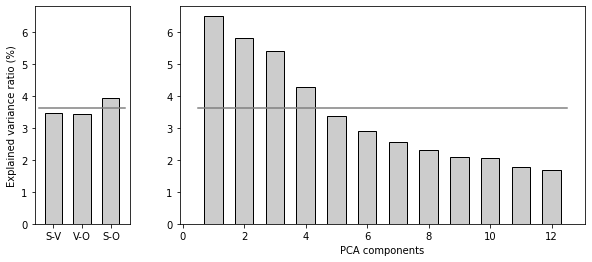

In [ ]:
plt.figure(figsize = (16, 4))
plt.subplot(1,8,4)
plt.bar(['S-V', 'V-O', 'S-O'], 100*var_ratio_SVM[:3], edgecolor='black',  color = [0.8,0.8,0.8],   width = 0.6);
plt.plot([-0.5,2.5], np.array([1,1])* np.mean(100*var_ratio_SVM[:3]), color='gray')
plt.ylim([0, 6.8]);  plt.ylabel('Explained variance ratio (%)');
plt.subplot(1,2,2)
plt.bar(np.arange(12)+1, 100*pca_val_ratio[:12], edgecolor='black',  color = [0.8,0.8,0.8],   width = 0.6);
plt.plot([0.5,12.5], np.array([1,1])* np.mean(100*var_ratio_SVM[:3]), color='gray')
plt.ylim([0, 6.8]);  plt.xlabel('PCA components');

In [ ]:
len(vocab), len(s_svm),len(s2_svm),len(s2_svc_h)

(1328, 1328, 2656, 2656)

In [ ]:
### validation sents for figs #### val(1st)+train(2nd) ###
val_end = 50;
val_end1 = np.where(first_w1==val_end);     val_end2 = np.where(s2_first_w1==val_end);
end1= val_end1[0][-1];                      end2=val_end2[0][-1];
end1, end2

(366, 417)

In [ ]:
val2 = np.concatenate([np.ones(end1, dtype=bool), np.zeros(len(svo_1)-end1, dtype=bool)])

In [ ]:
np.sum(svo_1[val2]==1+1), np.sum(svo_1[val2]==2+1), np.sum(svo_1[val2]==4+1), np.sum(svo_1[val2]==5+1)

(64, 68, 69, 0)

In [ ]:
svc_2,acc_2=[],[]
for i in range(6):
    y3 = svo_1 + 0;
    if i == 0:   sel = np.logical_or(svo_1==1+1,svo_1==2+1);   y3[~sel] = np.nan;
    elif i==1:   sel = np.logical_or(svo_1==2+1,svo_1==4+1);   y3[~sel] = np.nan;
    elif i==2:   sel = np.logical_or(svo_1==1+1,svo_1==4+1);   y3[~sel] = np.nan;
    elif i==3:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==2+1] = 4+1;    y3[~sel] = np.nan;
    elif i==4:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 4+1;    y3[~sel] = np.nan;
    elif i==5:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 2+1;    y3[~sel] = np.nan;
    tr = ~val2;  invalid = np.in1d(wd[np.logical_and(sel,tr)],wd[np.logical_and(sel,val2)]);  ind0 = np.argwhere(np.logical_and(sel,tr)); tr[ind0[invalid]] = False; ## removing overlapping data between training and test
    x_tr, y_tr = preprocess_svm(s_svm[np.logical_and(sel,tr),:], y3[np.logical_and(sel,tr)])
    x_test, y_test = preprocess_svm(s_svm[np.logical_and(sel,val2),:], y3[np.logical_and(sel,val2)])
    if len(x_tr)<16 or len(x_test)<5:   continue;
    svc.fit(x_tr, y_tr);     v_pred = svc.predict(x_test)
    acc_2.append( np.mean(v_pred == y_test)*100 );    svc_2.append(svc.coef_);

In [ ]:
######## trained by 51-end, tested by 1-50 #######
np.array(acc_2)

array([97.7, 99.3, 94.5, 96.9, 99.3, 95.7])

In [ ]:
svm_ax_np = np.concatenate(svm_ax, axis=1) # from linear SVM (using all data)
loss_his_np = np.stack(loss_his)

In [ ]:
########### data to save #################################################################################
data2 = {'loss_his':loss_his_np.tolist(), 'svm_ax':svm_ax_np.tolist(),  'acc_L':acc_L, 'acc_noL':acc_noL,
         'inc_tmstep_valrate':inc_tmstep_valrate[0:3] , 'val2_acc_a_41_42_61_0':val2_acc_a_41_42_61_0,
         'acc2_boat_noise_book':acc2_boat_noise_book,  'pca_val_ratio':pca_val_ratio.tolist(), 'var_ratio_SVM':var_ratio_SVM.tolist(),
         'acc_loc':acc_loc.tolist()
         }
##########################################################################################################

In [ ]:
svm_ax = [svc_2[i].T/np.linalg.norm(svc_2[i]) for i in range(len(svc_2))]   ######## trained by 51-end, tested by 1-50 #######

In [ ]:
from matplotlib import rc
rc('pdf', fonttype=42)

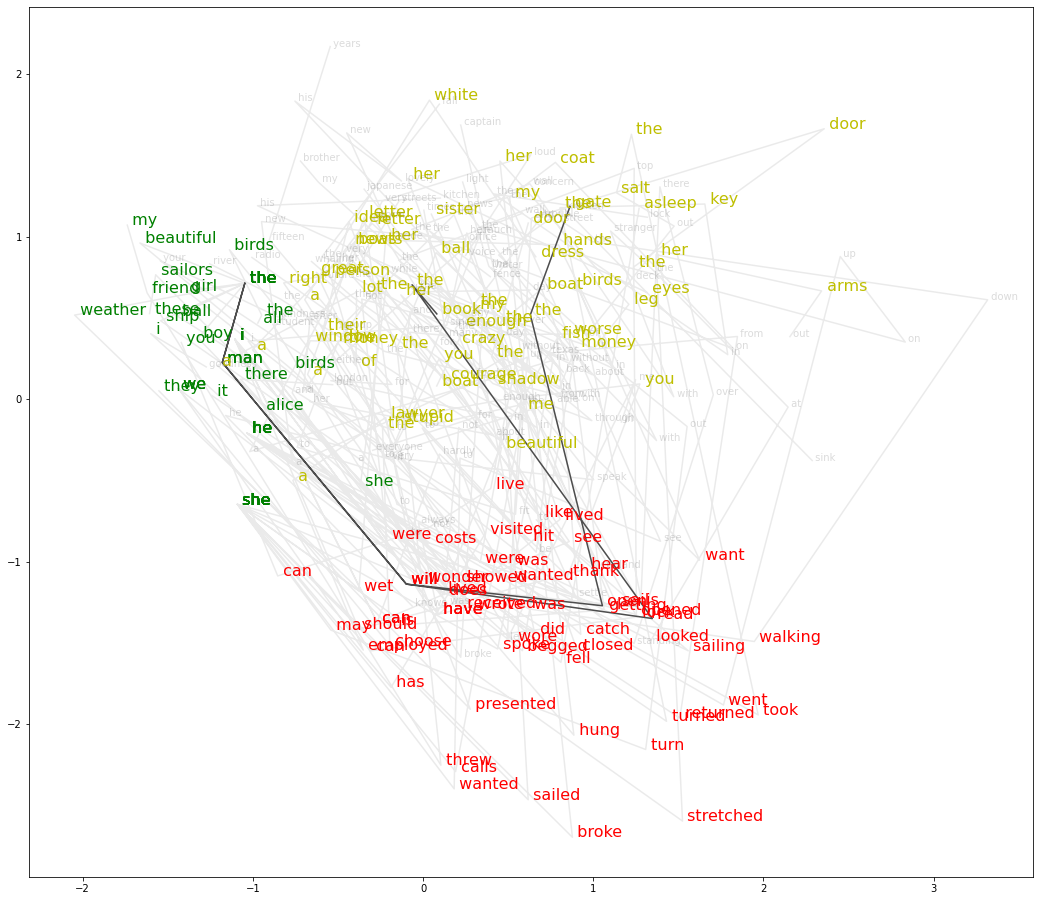

In [ ]:
pl = [0,1];
fig = plt.figure(figsize=(18, 16)) # figure area
plt.plot(s2_svm[:end2,:]@svm_ax[pl[0]], s2_svm[:end2,:]@svm_ax[pl[1]], color=[0.6, 0.6, 0.6, 0.2]);
plt.plot(s2_svc_h[:end2,:]@svm_ax[pl[0]],s2_svc_h[:end2,:]@svm_ax[pl[1]],color=[0.3, 0.3, 0.3])
for label, x1, y1, i in zip(vocab[:end1], s_svm[:end1,:]@svm_ax[pl[0]], s_svm[:end1,:]@svm_ax[pl[1]], range(end1)):
    # if first_w[i] == 1:
    #     plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='gray')
    label = " "+label
    if sv[i] == 1+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='g', fontsize=16)
    elif sv[i] == 2+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='r', fontsize=16) # verb or auxiliary verb
    elif sv[i] == 4+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='y', fontsize=16)
    else:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color=[0.3, 0.3, 0.3, 0.2])

In [ ]:
# fig.savefig('./saved_img/v'+'{0:03d}'.format(ver)+'_1.png', dpi=300)
fig.savefig('./saved_img/v'+'{0:03d}'.format(ver)+'_1' +str_c[rnn_cond]+ '.pdf')

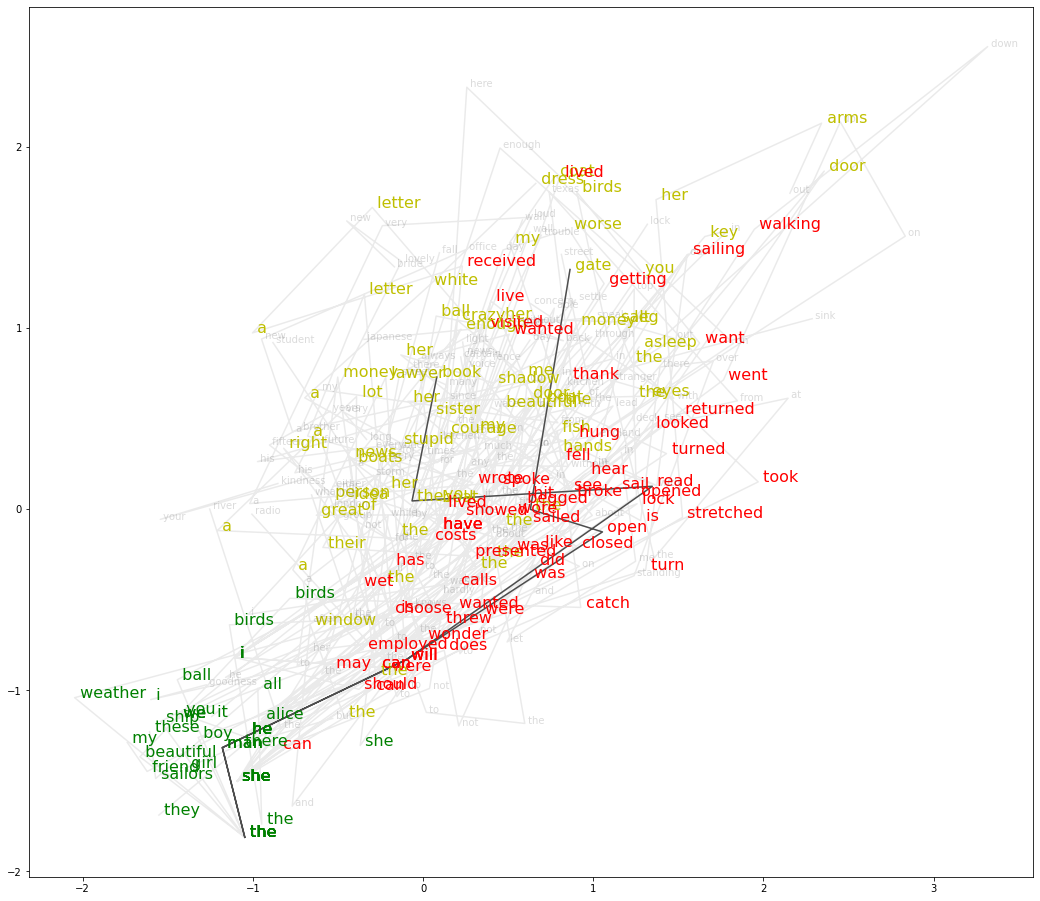

In [ ]:
pl = [0,2];
fig = plt.figure(figsize=(18, 16)) # figure area
plt.plot(s2_svm[:end2,:]@svm_ax[pl[0]], s2_svm[:end2,:]@svm_ax[pl[1]], color=[0.6, 0.6, 0.6, 0.2]);
plt.plot(s2_svc_h[:end2,:]@svm_ax[pl[0]],s2_svc_h[:end2,:]@svm_ax[pl[1]],color=[0.3, 0.3, 0.3])
for label, x1, y1, i in zip(vocab[:end1], s_svm[:end1,:]@svm_ax[pl[0]], s_svm[:end1,:]@svm_ax[pl[1]], range(end1)):
    # if first_w[i] == 1:
    #     plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='gray')
    label = " "+label
    if sv[i] == 1+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='g', fontsize=16)
    elif sv[i] == 2+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='r', fontsize=16)
    elif sv[i] == 4+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='y', fontsize=16)
    else:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color=[0.3, 0.3, 0.3, 0.2])

In [ ]:
fig.savefig('./saved_img/v'+'{0:03d}'.format(ver)+'_2' +str_c[rnn_cond]+ '.pdf')

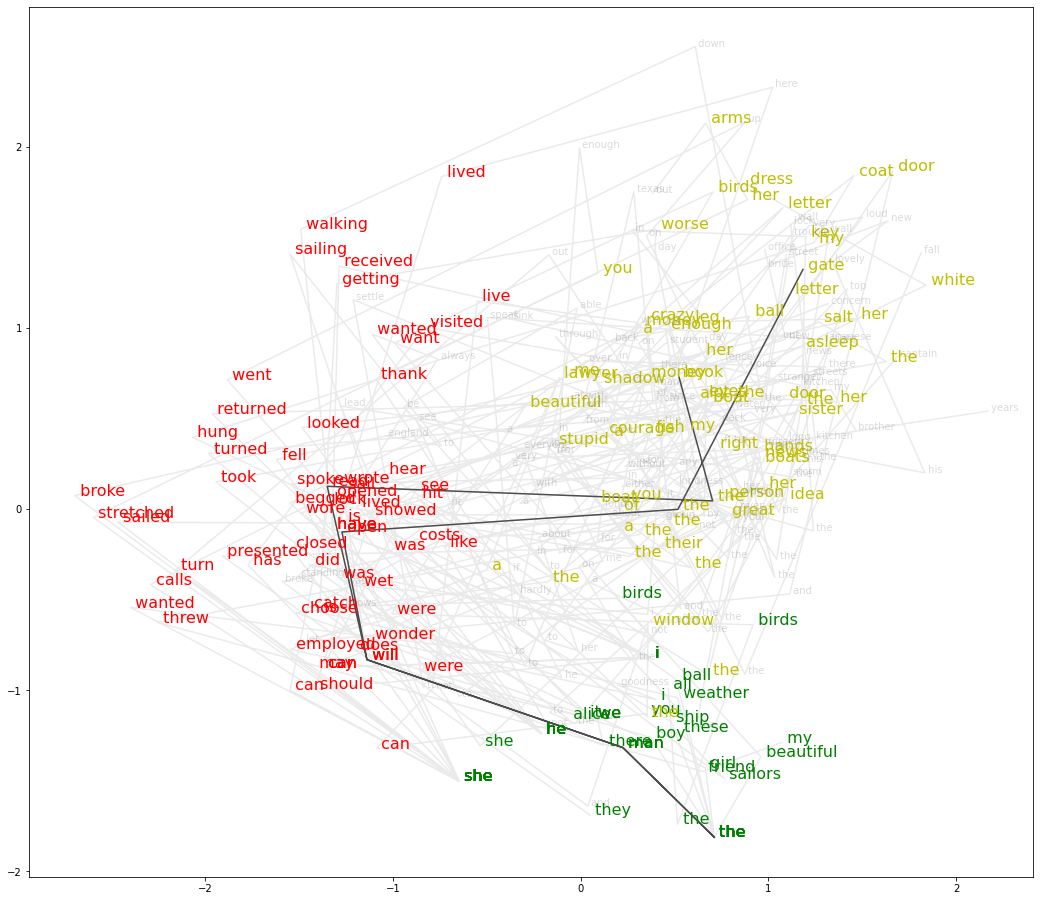

In [ ]:
pl = [1,2];
fig = plt.figure(figsize=(18, 16)) # figure area
plt.plot(s2_svm[:end2,:]@svm_ax[pl[0]], s2_svm[:end2,:]@svm_ax[pl[1]], color=[0.6, 0.6, 0.6, 0.2]);
plt.plot(s2_svc_h[:end2,:]@svm_ax[pl[0]],s2_svc_h[:end2,:]@svm_ax[pl[1]],color=[0.3, 0.3, 0.3])
for label, x1, y1, i in zip(vocab[:end1], s_svm[:end1,:]@svm_ax[pl[0]], s_svm[:end1,:]@svm_ax[pl[1]], range(end1)):
    # if first_w[i] == 1:
    #     plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='gray')
    label = " "+label
    if sv[i] == 1+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='g', fontsize=16)
    elif sv[i] == 2+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='r', fontsize=16)
    elif sv[i] == 4+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='y', fontsize=16)
    else:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color=[0.3, 0.3, 0.3, 0.2])

In [ ]:
fig.savefig('./saved_img/v'+'{0:03d}'.format(ver)+'_3' +str_c[rnn_cond]+ '.pdf')

In [ ]:
acc_pc = []
for j in range(10):
  ind = np.concatenate((np.arange(0,j),np.arange(j+1,32)))
  s_svm2 = s_pca[:,ind]; #  s2_svm = s2_pca[:,ind];  s2_svc_h = s2_pca_h[:,ind];
  svc_1,acc=[],[]
  for i in range(3):
      y3 = svo_1 + 0;
      if i == 0:   sel = np.logical_or(svo_1==1+1,svo_1==2+1);   y3[~sel] = np.nan;
      elif i==1:   sel = np.logical_or(svo_1==2+1,svo_1==4+1);   y3[~sel] = np.nan;
      elif i==2:   sel = np.logical_or(svo_1==1+1,svo_1==4+1);   y3[~sel] = np.nan;
      elif i==3:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==2+1] = 4+1;    y3[~sel] = np.nan;
      elif i==4:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 4+1;    y3[~sel] = np.nan;
      elif i==5:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 2+1;    y3[~sel] = np.nan;
      svc_,acc_=[],[]
      for sh in range(128): ## repeated SVM validation to get classification accuracy (%)
          val2=~~val; val2[:] = False; # to enter the while loop
          while np.sum(np.logical_and(sel,val2))<10:  val2=~~val; np.random.shuffle(val2);
          tr = ~val2;  invalid = np.in1d(wd[np.logical_and(sel,tr)],wd[np.logical_and(sel,val2)]);  ind0 = np.argwhere(np.logical_and(sel,tr)); tr[ind0[invalid]] = False;  ## removing overlapping data between training and test
          x_tr, y_tr = preprocess_svm(s_svm2[np.logical_and(sel,tr),:], y3[np.logical_and(sel,tr)])
          x_test, y_test = preprocess_svm(s_svm2[np.logical_and(sel,val2),:], y3[np.logical_and(sel,val2)])
          if len(x_tr)<16 or len(x_test)<5:   continue;
          svc.fit(x_tr, y_tr);        v_pred = svc.predict(x_test);
          acc_.append( np.mean(v_pred == y_test)*100 );        svc_.append(svc.coef_);
      acc.append(acc_);      svc_1.append(svc_);
  acc_pc.append( [np.mean(acc[i]) for i in range(len(acc))] )

In [ ]:
print(np.stack(acc_pc))

In [ ]:
acc_L_np = np.array(acc_L)
acc_pc_df = acc_L_np[:len(acc_pc[0])] - np.array(acc_pc)

In [ ]:
plt.figure(figsize=(16, 3)) # figure area
plt.plot(acc_pc_df);       plt.legend(['S-V','V-O',"S-O",'V-S/O'])
plt.xticks(np.arange(8)+0,np.arange(8)+1);
plt.xlabel('PC axis #');   plt.ylabel('Necessity to acc (%)');

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(12, 3)) # figure area
sns.heatmap(acc_pc_df[:,:3].T, cmap='Reds',vmin=0);
plt.xticks(np.arange(8)+0.5,np.arange(8)+1);
plt.yticks(np.arange(3)+0.5,['S-V','V-O',"S-O"]);
plt.xlabel('PCA components');

In [ ]:
plt.figure(figsize=(16, 3)) # figure area
for i in [0,1,2]:
    plt.plot(np.square(svm_ax[i][:16]));
plt.xticks(np.arange(8)+0,np.arange(8)+1);
plt.legend(['S-V','V-O',"S-O"])
plt.xlabel('PC axis #');   plt.ylabel('Similarity to SVM axis');

In [ ]:
svm_pca = np.square(np.squeeze(np.stack(svm_ax[:3])))

In [ ]:
plt.figure(figsize=(12, 3)) # figure area
sns.heatmap(svm_pca[:3,:16], cmap='Reds',vmin=0);
plt.xticks(np.arange(8)+0.5,np.arange(8)+1);
plt.yticks(np.arange(3)+0.5,['S-V','V-O',"S-O"]);
plt.xlabel('PCA components');

In [ ]:
!pip install mat4py
from mat4py import savemat

In [ ]:
########### data to save ###############
data2['acc_pc_df'] = acc_pc_df.tolist()
########################################

In [ ]:
fig = plt.figure(figsize=(16, 12)) # figure area
plt.plot(s2_pca[:,0],s2_pca[:,1], color=[0.6, 0.6, 0.6, 0.2])
plt.plot(s2_pca_h[:,0],s2_pca_h[:,1],color=[0.3, 0.3, 0.3])
for label, x1, y1, i in zip(vocab[:end1], s_pca[:end1, 0], s_pca[:end1, 1], range(end1)):
    if sv[i] == 1+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='g', fontsize=16)
    elif sv[i] == 2+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='r', fontsize=16)
    elif sv[i] == 4+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='y', fontsize=16)
    else:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color=[0.3, 0.3, 0.3, 0.2])
plt.xlabel('PC 1');   plt.ylabel('PC 2');

In [ ]:
fig.savefig('./saved_img/v'+'{0:03d}'.format(ver)+'_6' +str_c[rnn_cond]+ '.pdf')

In [ ]:
plt.figure(figsize=(16, 6)) # figure area
plt.plot(s2_pca[:,0],s2_pca[:,2], color=[0.6, 0.6, 0.6, 0.2])
for label, x1, y1, i in zip(vocab[:end1], s_pca[:end1, 0], s_pca[:end1, 2], range(end1)):
    if sv[i] == 1+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='g')
    elif sv[i] == 2+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='r')
    elif sv[i] == 4+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='y')
    else:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='gray')
plt.xlabel('PC 1');   plt.ylabel('PC 3');

In [ ]:
cmap=plt.get_cmap("jet");
bool_array = np.isin(3, np.array([1,2]))
np.logical_not(bool_array)
np.any(np.isin(first_w1[i],line_highlight))

In [ ]:
# s_pca_0

In [ ]:
fig = plt.figure(figsize=(16, 12)) # figure area
for label, x1, y1, i in zip(vocab[:end1], s_pca[:end1, 0], s_pca[:end1, 1], range(end1)):
      c1=np.array( cmap(np.mean(col_w[i:i+2])) );  c2=np.array( cmap(col_w[i]) );    lw=3.2/4;
      c1[-1] = 0.3; c2[-1] = 0.3;
      if np.logical_not(np.isin(first_w1[i],line_highlight)):
              if i<len(vocab)-1 and first_w[i+1] == 0:   plt.plot(s_pca[i:i+2,0],s_pca[i:i+2,1], color= c1, linewidth =lw )
              plt.annotate(" "+label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color=c2, fontsize=12)
for label, x1, y1, i in zip(vocab[:end1], s_pca[:end1, 0], s_pca[:end1, 1], range(end1)):
      c1=np.array( cmap(np.mean(col_w[i:i+2])) );  c2=np.array( cmap(col_w[i]) );   lw = 3.2;
      c1 = 0.9*c1+ 0.1*np.array([0,0,0,1]);    c2 = 0.6*c2+ 0.4*np.array([0,0,0,1]);
      if np.any(np.isin(first_w1[i],line_highlight)):
              if i<len(vocab)-1 and first_w[i+1] == 0:    plt.plot(s_pca[i:i+2,0],s_pca[i:i+2,1], color= c1, linewidth =lw )
              if i<len(vocab)-1 and first_w[i] == 1:      plt.plot([s_pca_0[:,0],s_pca[i,0]], [s_pca_0[:,1],s_pca[i,1]], 'o-', color= 'black', linewidth =lw//4 )
              plt.annotate(" "+label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color=c2, fontsize=18)

plt.xlabel('PC 1');   plt.ylabel('PC 2');

In [ ]:
fig.savefig('./saved_img/v'+'{0:03d}'.format(ver)+'_4' +str_c[rnn_cond]+ '.pdf')

In [ ]:
pl = [0, 2]
fig = plt.figure(figsize=(16, 12)) # figure area
for label, x1, y1, i in zip(vocab[:end1], s_pca[:end1, pl[0]], s_pca[:end1, pl[1]], range(end1)):
      c1=np.array( cmap(np.mean(col_w[i:i+2])) );  c2=np.array( cmap(col_w[i]) );    lw=3.2/4;
      c1[-1] = 0.25; c2[-1] = 0.25;
      if np.logical_not(np.isin(first_w1[i],line_highlight)):
              if i<len(vocab)-1 and first_w[i+1] == 0:   plt.plot(s_pca[i:i+2,pl[0]],s_pca[i:i+2,pl[1]], color= c1, linewidth =lw )
              plt.annotate(" "+label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color=c2, fontsize=12)
for label, x1, y1, i in zip(vocab[:end1], s_pca[:end1, pl[0]], s_pca[:end1, pl[1]], range(end1)):
      c1=np.array( cmap(np.mean(col_w[i:i+2])) );  c2=np.array( cmap(col_w[i]) );   lw = 3.2;
      c1 = 0.9*c1+ 0.1*np.array([0,0,0,1]);    c2 = 0.6*c2+ 0.4*np.array([0,0,0,1]);
      if np.any(np.isin(first_w1[i],line_highlight)):
              if i<len(vocab)-1 and first_w[i+1] == 0:  plt.plot(s_pca[i:i+2,pl[0]],s_pca[i:i+2,pl[1]], color= c1, linewidth =lw )
              plt.annotate(" "+label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color=c2, fontsize=18)
plt.plot(s_pca_0[:,0], s_pca_0[:,1], 'o-', color= 'black')
plt.xlabel('PC '+str(pl[0]+1));   plt.ylabel('PC '+str(pl[1]+1));

In [ ]:
fig.savefig('./saved_img/v'+'{0:03d}'.format(ver)+'_5' +str_c[rnn_cond]+ '.pdf')

In [ ]:
s_pca_1 = np.concatenate((s_pca_0,s_pca),axis=0)
s_pca_1[[0,i+1],pl[1]]
s_pca_0[:,pl[0]]

In [ ]:
pl = [2,1,0]
fig = plt.figure(figsize=(16, 12)) # figure area
ax = plt.axes(projection='3d')
for label, x1, y1, z1, i in zip(vocab[:end1], s_pca[:end1, pl[0]],s_pca[:end1, pl[1]], s_pca[:end1, pl[2]], range(end1)):
      c1=np.array( cmap(np.mean(col_w[i:i+2])) );  c2=np.array( cmap(col_w[i]) );    lw=3.2/4;
      c1[-1] = 0.25; c2[-1] = 0.25;
      if np.logical_not(np.isin(first_w1[i],line_highlight)):
              if i<len(vocab)-1 and first_w[i+1] == 0:   ax.plot3D(s_pca[i:i+2,pl[0]],s_pca[i:i+2,pl[1]],s_pca[i:i+2,pl[2]], color= c1, linewidth =lw )
              ax.text(x1,y1,z1, " "+label,   color=c2, fontsize=12)
for label, x1, y1, z1, i in zip(vocab[:end1], s_pca[:end1, pl[0]], s_pca[:end1, pl[1]], s_pca[:end1, pl[2]], range(end1)):
      c1=np.array( cmap(np.mean(col_w[i:i+2])) );  c2=np.array( cmap(col_w[i]) );   lw = 3.2;
      c1 = 0.9*c1+ 0.1*np.array([0,0,0,1]);    c2 = 0.6*c2+ 0.4*np.array([0,0,0,1]);
      if np.any(np.isin(first_w1[i],line_highlight)):
              if i<len(vocab)-1 and first_w[i+1] == 0:  ax.plot3D(s_pca[i:i+2,pl[0]],s_pca[i:i+2,pl[1]],s_pca[i:i+2,pl[2]], color= c1, linewidth =lw )
              ax.text(x1, y1, z1, " "+label,  color=c2, fontsize=18)
              if i<len(vocab)-1 and first_w[i] == 1:
                  ax.plot3D(s_pca_1[[0,i+1],pl[0]],s_pca_1[[0,i+1],pl[1]],s_pca_1[[0,i+1],pl[2]], color= 'black' )
                  # ax.plot3D(s_pca_0[:,pl[0]], s_pca_0[:,pl[1]], s_pca_0[:,pl[2]], 'o', color= 'black')
plt.xlabel('PC '+str(pl[0]+1));   plt.ylabel('PC '+str(pl[1]+1));

In [ ]:
ax.view_init(20, 80)
fig

In [ ]:
fig.savefig('./saved_img/v'+'{0:03d}'.format(ver)+'_7' +str_c[rnn_cond]+ '.pdf')

In [ ]:
pca_eg = pca.components_

=========== analysis for input cells ========

In [ ]:
svc_nL = svm.NuSVC(nu=0.1, kernel='rbf', max_iter=2*64000)
svc_L  = svm.SVC(kernel='linear', class_weight='balanced', max_iter=16*64000)   # kernel =‘linear'

In [ ]:
val_ratio = 10
val = np.concatenate([np.zeros(len(svo_1)-len(svo_1)*val_ratio//100, dtype=bool), np.ones(len(svo_1)*val_ratio//100, dtype=bool)])
tr = ~val

In [ ]:
i_ori = np.concatenate(r_in,axis=0);
pca = PCA()
pca.fit(i_ori)
i_pca = pca.transform(i_ori)
i_svm = i_pca[:,:];
# i_svm = i_pca[:,:128];

In [ ]:
# ============= svm ===================
ac_L, ac_nL = [],[]
for i in range(6):
    y3 = svo_1 + 0;
    if i == 0:   sel = np.logical_or(svo_1==1+1,svo_1==2+1);   y3[~sel] = np.nan;
    elif i==1:   sel = np.logical_or(svo_1==2+1,svo_1==4+1);   y3[~sel] = np.nan;
    elif i==2:   sel = np.logical_or(svo_1==1+1,svo_1==4+1);   y3[~sel] = np.nan;
    elif i==3:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==2+1] = 4+1;    y3[~sel] = np.nan;
    elif i==4:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 4+1;    y3[~sel] = np.nan;
    elif i==5:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 2+1;    y3[~sel] = np.nan;
    acc_L_,acc_nL_=[],[]
    for sh in range(256): ## repeated SVM validation to get classification accuracy (%)
        val2=~~val; val2[:] = False; # to enter the while loop
        while np.sum(np.logical_and(sel,val2))<10:  val2=~~val; np.random.shuffle(val2);
        tr = ~val2;  invalid = np.in1d(wd[np.logical_and(sel,tr)],wd[np.logical_and(sel,val2)]);  ind0 = np.argwhere(np.logical_and(sel,tr)); tr[ind0[invalid]] = False;  ## removing overlapping data between training and test
        x_tr, y_tr = preprocess_svm(i_svm[np.logical_and(sel,tr),:], y3[np.logical_and(sel,tr)])
        x_test, y_test = preprocess_svm(i_svm[np.logical_and(sel,val2),:], y3[np.logical_and(sel,val2)])
        if len(x_tr)<16 or len(x_test)<5:   continue;
        svc_L.fit(x_tr, y_tr);   y_pred = svc_L.predict(x_test);    acc_L_.append( np.mean(y_pred == y_test)*100 );
        svc_nL.fit(x_tr, y_tr);  y_pred = svc_nL.predict(x_test);   acc_nL_.append( np.mean(y_pred == y_test)*100 );
    ac_L.append(acc_L_);    ac_nL.append(acc_nL_);

In [ ]:
# S-V, V-O, S-O, S, V, O  # Linear SVM
acc_L_i = [np.mean(ac_L[i]) for i in range(len(ac_L))]
acc_nL_i = [np.mean(ac_nL[i]) for i in range(len(ac_nL))]
print(np.array(acc_L_i))
print(np.array(acc_nL_i))

=========== analysis for output cells ========

In [ ]:
o_ori = np.concatenate(r_out,axis=0);
pca = PCA()
pca.fit(o_ori)
o_pca = pca.transform(o_ori)
# o_svm = o_pca[:,:];
o_svm = o_pca[:,:64];

In [ ]:
# ============= svm ===================
ac_L, ac_nL = [],[]
for i in range(6):
    y3 = svo_1 + 0;
    if i == 0:   sel = np.logical_or(svo_1==1+1,svo_1==2+1);   y3[~sel] = np.nan;
    elif i==1:   sel = np.logical_or(svo_1==2+1,svo_1==4+1);   y3[~sel] = np.nan;
    elif i==2:   sel = np.logical_or(svo_1==1+1,svo_1==4+1);   y3[~sel] = np.nan;
    elif i==3:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==2+1] = 4+1;    y3[~sel] = np.nan;
    elif i==4:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 4+1;    y3[~sel] = np.nan;
    elif i==5:   sel = np.logical_and(svo_1>=1+1,svo_1<=4+1);  y3[svo_1==1+1] = 2+1;    y3[~sel] = np.nan;
    acc_L_,acc_nL_=[],[]
    for sh in range(256): ## repeated SVM validation to get classification accuracy (%)
        val2=~~val; val2[:] = False; # to enter the while loop
        while np.sum(np.logical_and(sel,val2))<10:  val2=~~val; np.random.shuffle(val2);
        tr = ~val2;  invalid = np.in1d(wd[np.logical_and(sel,tr)],wd[np.logical_and(sel,val2)]);  ind0 = np.argwhere(np.logical_and(sel,tr)); tr[ind0[invalid]] = False;  ## removing overlapping data between training and test
        x_tr, y_tr = preprocess_svm(o_svm[np.logical_and(sel,tr),:], y3[np.logical_and(sel,tr)])
        x_test, y_test = preprocess_svm(o_svm[np.logical_and(sel,val2),:], y3[np.logical_and(sel,val2)])
        if len(x_tr)<16 or len(x_test)<5:   continue;
        svc_L.fit(x_tr, y_tr);   y_pred = svc_L.predict(x_test);    acc_L_.append( np.mean(y_pred == y_test)*100 );
        svc_nL.fit(x_tr, y_tr);  y_pred = svc_nL.predict(x_test);   acc_nL_.append( np.mean(y_pred == y_test)*100 );
    ac_L.append(acc_L_);    ac_nL.append(acc_nL_);

In [ ]:
# S-V, V-O, S-O, S, V, O  # Linear SVM
acc_L_o_0 = [np.mean(ac_L[i]) for i in range(len(ac_L))]
acc_nL_o_0 = [np.mean(ac_nL[i]) for i in range(len(ac_nL))]
print(np.array(acc_L_o_0))
print(np.array(acc_nL_o_0))

In [ ]:
ii=0;  o2_pca = np.NaN*np.zeros((2*len(first_w),np.size(o_pca,1)));
for i in range(len(first_w)):
    if first_w[i]==1:      ii = ii +1;
    ii = ii +1;    o2_pca[ii,:] = o_pca[i,:];

In [ ]:
fig = plt.figure(figsize=(16, 12)) # figure area
plt.plot(o2_pca[:,0],o2_pca[:,1], color=[0.6, 0.6, 0.6, 0.2])
# plt.plot(s2_pca_h[:,0],s2_pca_h[:,1],color=[0.3, 0.3, 0.3])
for label, x1, y1, i in zip(vocab[:end1], o_pca[:end1, 0], o_pca[:end1, 1], range(end1)):
    if sv[i] == 1+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='g', fontsize=16)
    elif sv[i] == 2+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='r', fontsize=16)
    elif sv[i] == 4+1:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color='y', fontsize=16)
    else:
        plt.annotate(label, xy=(x1, y1), xytext=(0, 0), textcoords='offset points',  color=[0.3, 0.3, 0.3, 0.2])
plt.xlabel('PC 1');   plt.ylabel('PC 2');

In [ ]:
fig.savefig('./saved_img/v'+'{0:03d}'.format(ver)+'_8' +str_c[rnn_cond]+ '.pdf')

=========== output cell activity vs next-word ============

In [ ]:
svo_p = svo_1[1:];  wd_p = wd[1:];  first_w_p = first_w[1:];  # one-word shift
svo_p[first_w_p==1] = 0;  # removing the prediction of the first word of the sentence.
o_svm_p = o_svm[:-1,:]

In [ ]:
val_ratio = 10
val = np.concatenate([np.zeros(len(o_svm_p)-len(o_svm_p)*val_ratio//100, dtype=bool), np.ones(len(o_svm_p)*val_ratio//100, dtype=bool)])
tr = ~val

In [ ]:
# ============= svm ===================
ac_L, ac_nL = [],[]
for i in range(6):
    y3 = svo_p + 0;
    if i == 0:   sel = np.logical_or(y3==1+1,y3==2+1);   y3[~sel] = np.nan;
    elif i==1:   sel = np.logical_or(y3==2+1,y3==4+1);   y3[~sel] = np.nan;
    elif i==2:   sel = np.logical_or(y3==1+1,y3==4+1);   y3[~sel] = np.nan;
    elif i==3:   sel = np.logical_and(y3>=1+1,y3<=4+1);  y3[y3==2+1] = 4+1;    y3[~sel] = np.nan;
    elif i==4:   sel = np.logical_and(y3>=1+1,y3<=4+1);  y3[y3==1+1] = 4+1;    y3[~sel] = np.nan;
    elif i==5:   sel = np.logical_and(y3>=1+1,y3<=4+1);  y3[y3==1+1] = 2+1;    y3[~sel] = np.nan;
    acc_L_,acc_nL_=[],[]
    for sh in range(256): ## repeated SVM validation to get classification accuracy (%)
        val2=~~val; val2[:] = False; # to enter the while loop
        while np.sum(np.logical_and(sel,val2))<10:  val2=~~val; np.random.shuffle(val2);
        tr = ~val2;  invalid = np.in1d(wd_p[np.logical_and(sel,tr)],wd_p[np.logical_and(sel,val2)]);  ind0 = np.argwhere(np.logical_and(sel,tr)); tr[ind0[invalid]] = False;  ## removing overlapping data between training and test
        x_tr, y_tr = preprocess_svm(o_svm_p[np.logical_and(sel,tr),:], y3[np.logical_and(sel,tr)])
        x_test, y_test = preprocess_svm(o_svm_p[np.logical_and(sel,val2),:], y3[np.logical_and(sel,val2)])
        if len(x_tr)<16 or len(x_test)<5:   continue;
        svc_L.fit(x_tr, y_tr);   y_pred = svc_L.predict(x_test);    acc_L_.append( np.mean(y_pred == y_test)*100 );
        svc_nL.fit(x_tr, y_tr);  y_pred = svc_nL.predict(x_test);   acc_nL_.append( np.mean(y_pred == y_test)*100 );
    ac_L.append(acc_L_);    ac_nL.append(acc_nL_);

In [ ]:
# S-V, V-O, S-O, S, V, O  # Linear SVM
acc_L_o_1 = [np.mean(ac_L[i]) for i in range(len(ac_L))]
acc_nL_o_1 = [np.mean(ac_nL[i]) for i in range(len(ac_nL))]
print(np.array(acc_L_o_1))
print(np.array(acc_nL_o_1))

In [ ]:
acc_L_io = np.stack((acc_L_i,acc_L,acc_L_o_0,acc_L_o_1))
acc_nL_io = np.stack((acc_nL_i,acc_noL,acc_nL_o_0,acc_nL_o_1))

In [ ]:
acc_L_io, acc_nL_io

In [ ]:
########### linera SVM ##############
plt.figure(figsize=(12, 3)) # figure area
plt.subplot(1,2,1)
plt.plot(acc_L_io[:3,3:4],  color='g');
plt.plot(acc_L_io[:3,4:5],  color='r');
plt.plot(acc_L_io[:3,5:],  color='y');
plt.legend(['S','V','O'])
plt.xticks(np.arange(3)+0,['Input','Purkinje','Output']);  plt.title('Word-class information for the last word');
plt.ylabel('Separation by SVM (%)')
plt.ylim(50,100);
plt.subplot(1,4,3)
plt.plot(acc_L_io[-1:,3:4], 'o',  color='g');
plt.plot(acc_L_io[-1:,4:5], 'o', color='r');
plt.plot(acc_L_io[-1:,5:],  'o', color='y');
plt.xticks([0],['Output']);       plt.title('Word-class information for the next word');
plt.ylim(50,100);

In [ ]:
########### non-linera SVM ##############
plt.figure(figsize=(12, 3)) # figure area
plt.subplot(1,2,1)
plt.plot(acc_nL_io[:3,3:4],  color='g');
plt.plot(acc_nL_io[:3,4:5],  color='r');
plt.plot(acc_nL_io[:3,5:],   color='y');
plt.legend(['S','V','O'])
plt.xticks(np.arange(3)+0,['Input','Purkinje','Output']);  plt.title('Word-class information for the last word');
plt.ylabel('Separation by SVM (%)')
plt.plot([-0.3,2.3],[50,50],  color='gray');  plt.ylim(44,100);
plt.subplot(1,4,3)
plt.plot(acc_nL_io[-1:,3:4], 'o',  color='g');
plt.plot(acc_nL_io[-1:,4:5], 'o',  color='r');
plt.plot(acc_nL_io[-1:,5:],  'o',  color='y');
plt.xticks([0],['Output']);       plt.title('Word-class information for the next word');
plt.plot([-0.3,0.3],[50,50],  color='gray');  plt.ylim(44,100);

In [ ]:
########### data to save ###############
data2['acc_L_io'] = acc_L_io.tolist();  data2['acc_nL_io'] = acc_nL_io.tolist();
########################################
str_c2 = ['','_i','_i_dp'];

In [ ]:
########### savin data with matlab format ###############
savemat('./saved_mat/v'+str(ver) +str_c2[rnn_cond]+ '.mat', data2)
#########################################################